# Machine Learning in Network Science
Final Project

***
by: Leonardo Basili, Paul Bédier, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

This notebook covers classical unsupervised link prediction techniques.

### 1. Import Packages

In [42]:
from importlib import reload
reload(analyseData)
reload(prepData)
reload(loadData)
reload(modeling)
reload(autoenc)

<module 'util.autoencoder' from '/Users/macbookpro/Documents/GitHub/Network-Science_Final-Project/util/autoencoder.py'>

In [ ]:
# import own scripts
import util.analyse_Data as analyseData
import util.preprocess_Data as prepData
import util.load_Data as loadData
import util.modeling as modeling
import util.autoencoder as autoenc

In [2]:
# basic stuff
from itertools import product, combinations
from collections import OrderedDict

# parse & handle data
import os
import csv
import numpy as np
import pandas as pd
import networkx as nx # graph data
import sknetwork

# modeling
import torch
from torch_geometric.nn import GAE, VGAE
from xgboost import XGBClassifier
import sknetwork

# evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data for Modeling

In [4]:
# might take up to a few minutes
(G, G_train, G_trainval, node_info,
 train_tf, val_tf, trainval_tf, test_tf,
 X_train, y_train, X_val, y_val, X_trainval, y_trainval,
 X_test, y_test) = loadData.load_transform(val_ratio = 0.2, test_ratio = 0.1, n2v_train=False)

Number of positive edges for training: 3802
Number of positive edges for validation: 1085
Number of positive edges for test: 542
Number of edges in original graph: 5429
Number of edges in training graph: 3802
Number of non-existing edges generated: 29971
Number of negative edges for training: 3802
Number of negative edges for validation: 1085
Number of negative edges for test: 542


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  4.71it/s]


Enriching train data...


c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:130: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:99: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c

Enriching validation data...


c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:130: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:99: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c

Enriching test data...


c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:130: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:99: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c

In [5]:
# might take up to a minute
data, _ = autoenc.load(val_ratio = 0.2, test_ratio = 0.1)

Number of positive edges for training: 3802
Number of positive edges for validation: 1085
Number of positive edges for test: 542
Number of edges in original graph: 5429
Number of edges in training graph: 3802
Number of non-existing edges generated: 29971
Number of negative edges for training: 3802
Number of negative edges for validation: 1085
Number of negative edges for test: 542
Enriching node features...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.82it/s]
c:\Users\pbedi\miniconda3\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)
Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.55it/s]
c:\Users\pbedi\miniconda3\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


Create PyTorch Geometric dataset...


In [6]:
# get node embeddings (IF YOU CHANGE SEED = 42, then you need to train new autoencoder as train-val split is different)

# load best autoencoder
path = os.path.abspath("")+"/models/VGNAE_0.001_0_4982a_00000_autoencoder.pt"
model = VGAE(autoenc.Encoder(data.x.size()[1], 64, 1.2, 5, 0.2, 0))
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

# get embeddings of nodes
embedding = autoenc.get_embeddings(model, data.x, data.trainval_edges)
node_emb = pd.DataFrame(embedding).rename(columns = {val: f"x{val+1}" for val in range(embedding.shape[1])})

# enrich train
train_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.train_edges)).rename(columns = {0: "sim"})
train_tf = (train_tf
    .assign(sim = train_sim.sim.values)
    .assign(sim_scaled = (train_sim.sim.values - train_sim.sim.values.min()) / (train_sim.sim.values.max() - train_sim.sim.values.min()))
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.source, df_.target)])
)

# enrich val
val_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.val_edges)).rename(columns = {0: "sim"})
val_tf = (val_tf
    .assign(sim = val_sim.sim.values)
    .assign(sim_scaled = (val_sim.sim.values - val_sim.sim.values.min()) / (val_sim.sim.values.max() - val_sim.sim.values.min()))
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.source, df_.target)])
)

# enrich test
test_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.trainval_pos_edges, data.test_edges)).rename(columns = {0: "sim"})
test_tf = (test_tf
    .assign(sim = test_sim.sim.values)
    .assign(sim_scaled = (test_sim.sim.values - test_sim.sim.values.min()) / (test_sim.sim.values.max() - test_sim.sim.values.min()))
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.source, df_.target)])
)

# split
X_train, y_train = loadData.split_frame(train_tf)
X_val, y_val     = loadData.split_frame(val_tf)
X_test, y_test   = loadData.split_frame(test_tf)

In [7]:
X_train

,train_mask,val_mask,nodeInfo_dupl,nodeInfo_diff,source_DCT,target_DCT,BCT_diff,CNC,RA,CF_RA,...,node2vec_1,node2vec_2,node2vec_3,node2vec_4,friendLink,PR1,PR2,sim,sim_scaled,dist
0,True,False,0,40,0.001847,0.046177,1.342636e-04,542.400000,0.111111,1.130556,...,0.557322,0.779174,0.494215,0.917757,0.0,0.004162,5.753754e-05,0.998753,0.998675,9.055797
1,True,False,0,39,0.001108,0.046177,1.363114e-04,541.600000,0.000000,0.000000,...,0.614369,0.328962,0.216377,0.515915,0.0,0.004186,5.679651e-05,0.636057,0.612702,9.775298
2,True,False,0,37,0.002216,0.046177,1.359018e-04,544.000000,0.809524,2.804690,...,0.587787,0.130012,0.149948,0.365877,0.0,0.004183,5.688328e-05,0.999914,0.999911,9.665353
5,True,False,0,37,0.000369,0.046177,1.371304e-04,541.600000,0.000000,0.000000,...,0.428645,4.268373,3.676869,1.702030,0.0,0.004121,5.876902e-05,0.996487,0.996264,9.817258
6,True,False,0,43,0.001108,0.046177,1.371304e-04,542.400000,0.333333,0.333333,...,0.823369,1.817174,0.853767,1.267613,0.0,0.004121,5.876902e-05,0.994311,0.993949,10.429521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9227,True,False,0,27,0.001108,0.001108,0.000000e+00,67.700000,0.000000,0.000000,...,0.000192,0.016350,0.128137,0.001505,0.0,0.000288,0.000000e+00,0.597308,0.571467,10.637479
9228,True,False,0,32,0.001108,0.000369,0.000000e+00,54.160000,0.000000,0.000000,...,0.007723,0.001882,0.274254,0.004281,0.0,0.000299,4.676405e-10,0.559727,0.531474,9.179521
9229,True,False,0,27,0.001108,0.000739,2.730322e-07,77.371429,0.000000,0.000000,...,0.275307,1.656123,0.010893,1.768062,0.0,0.000314,2.707818e-09,0.616462,0.591851,9.208045
9230,True,False,0,31,0.001108,0.000739,0.000000e+00,135.400000,0.000000,0.000000,...,0.011130,0.847377,0.120725,0.241216,0.0,0.000288,0.000000e+00,0.579638,0.552663,8.466405


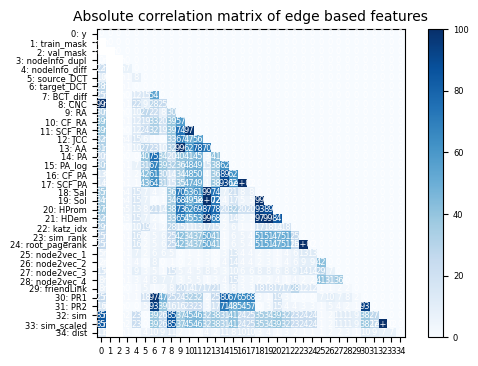

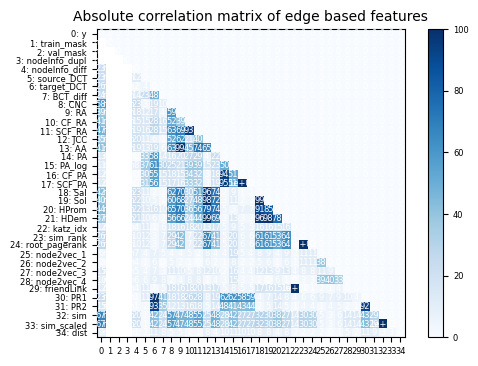

In [8]:
# plot correlation with target (first train, then validation)
for df in [train_tf, val_tf]:
    analyseData.plot_corr_matrix(df.iloc[:, 2:])

### 3. Unsupervised Link Prediction

In [9]:
def compute_score(df, cols, method, thresh):
    # we assume that all metrics get better with increasing values!
    
    df_ = df[list(cols)]
    
    if method == "rank_avg":
        df_ = df_.rank(pct = True).mean(axis = 1)  
    elif method == "avg":
        df_ = df_.mean(axis = 1)
    elif method == "whitened_sigmoid_avg":
        df_ = pd.DataFrame({col: sknetwork.linkpred.whitened_sigmoid(df_[col].to_numpy()) for col in df_.columns})
        df_ = df_.mean(axis = 1)
        
    if thresh == "top50%":
        y_hat = (df_ > df_.median()).astype(int)
    elif thresh == "thresh":
        y_hat = (df_ > 0.5).astype(int)
    elif thresh == "return_probas":
        y_hat = df_.rank(pct = True)
        
    return y_hat

We only consider a subset of somewhat decorrelated metrics (otherwise this search will run too long). For example, Sorensen Index is highly correlated (.99) with Salton Index, thus it is enough to only include one of them in our below search (same for Adamic Adar and Resource Allocation, but not for Adamic Adar and SCF Resource Allocation).

In [26]:
# which cols we want to use for link prediction
res = OrderedDict()
cols = ["CNC", "SCF_RA", "JCC", "AA", "PA_log", "SoI", "HProm", # local methods
        "katz_idx", "sim_rank", "root_pagerank", "node2vec_1", "node2vec_4", # global methods
        "friendLink", "sim", "sim_scaled"]                                           # quasi-local methods

methods = ["rank_avg", "avg", "whitened_sigmoid_avg"]
threshs = ["top50%", "thresh"]

# generate all combinations of columns in cols
sampled_cols = []
for n in range(2, len(cols) + 1):
    sampled_cols += list([c for c in combinations(cols, n)])

for s, m, t in tqdm(product(sampled_cols, methods, threshs)):
    y_train_hat = compute_score(X_train, s, m, t)
    y_val_hat   = compute_score(X_val, s, m, t)
    y_test_hat   = compute_score(X_test, s, m, t)
    trn_acc     = accuracy_score(y_train, y_train_hat)
    val_acc     = accuracy_score(y_val, y_val_hat)
    test_acc     = accuracy_score(y_test, y_test_hat)

    res[(s, m, t)] = {"trn_acc": trn_acc, "val_acc": val_acc, "test_acc": test_acc}

196512it [53:30, 61.21it/s]


In [28]:
ordered_res = (sorted(res.items(), key = lambda kv: kv[1]["val_acc"], reverse = True))

for (col, m, t), val_dict in ordered_res[0:10]:
    print(f"using {col}, {m}, {t}")
    print(f"Train Accuracy {round(val_dict['trn_acc'], 5)}, Val Accuracy {round(val_dict['val_acc'], 5)}, Test Accuracy {round(val_dict['test_acc'], 5)}\n")

using ('SCF_RA', 'JCC', 'AA', 'SoI', 'HProm', 'sim_rank', 'sim', 'sim_scaled'), whitened_sigmoid_avg, thresh
Train Accuracy 0.95371, Val Accuracy 0.88065, Test Accuracy 0.90037

using ('SCF_RA', 'JCC', 'AA', 'SoI', 'HProm', 'root_pagerank', 'sim', 'sim_scaled'), whitened_sigmoid_avg, thresh
Train Accuracy 0.95371, Val Accuracy 0.88065, Test Accuracy 0.90037

using ('SCF_RA', 'JCC', 'AA', 'SoI', 'HProm', 'katz_idx', 'sim_rank', 'sim', 'sim_scaled'), whitened_sigmoid_avg, thresh
Train Accuracy 0.96002, Val Accuracy 0.88065, Test Accuracy 0.89945

using ('SCF_RA', 'JCC', 'AA', 'SoI', 'HProm', 'katz_idx', 'root_pagerank', 'sim', 'sim_scaled'), whitened_sigmoid_avg, thresh
Train Accuracy 0.96002, Val Accuracy 0.88065, Test Accuracy 0.89945

using ('SCF_RA', 'JCC', 'AA', 'SoI', 'HProm', 'sim_rank', 'friendLink', 'sim', 'sim_scaled'), whitened_sigmoid_avg, thresh
Train Accuracy 0.95529, Val Accuracy 0.88065, Test Accuracy 0.89945

using ('SCF_RA', 'JCC', 'AA', 'SoI', 'HProm', 'root_pagerank',

In [29]:
# use best settings
s = ['SCF_RA', 'JCC', 'AA', 'SoI', 'HProm', 'sim_rank', 'sim', 'sim_scaled']
m = "whitened_sigmoid_avg"
t = "thresh"
y_train_hat = compute_score(X_train, s, m, t)
y_val_hat   = compute_score(X_val, s, m, t)
y_test_hat  = compute_score(X_test, s, m, t)

In [31]:
# detailed performance analysis
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))

Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3802
           1       0.95      0.95      0.95      3802

    accuracy                           0.95      7604
   macro avg       0.95      0.95      0.95      7604
weighted avg       0.95      0.95      0.95      7604

Test performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.95      0.90       542
           1       0.94      0.85      0.90       542

    accuracy                           0.90      1084
   macro avg       0.90      0.90      0.90      1084
weighted avg       0.90      0.90      0.90      1084

Roc_auc score
-------------------------------------------------------
0.9003690036900369

Confusion matrix
-------------------------------------------------------
[[513  29]
 [ 79 463]]
